This notebook merges the dataset created by dataset_generation_amplifier.py and merges the parameters into a single file.
This dataset is then used by AIFeynman to find parameter dependencies between the transport properties and the coupling parameters, see symbolic_regression.py.

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax
from tqdm import tqdm
import autolattice.architecture_optimizer as arch_opt
import autolattice.plothelpers as phelp

import os
import glob
import pickle

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

# load all files from the dataset
load_folder = 'results/amplifier_dataset'
all_files = glob.glob(os.path.join(load_folder,'procid*,run*.pkl'))

# load again the optimizer class
# this allows us to compute and plot all transport characteristics of the discovered amplifiers
kwargs_bounds = {'bounds_extrinsic_loss': [0., np.inf]}
optimizer = arch_opt.Architecture_Optimizer(
    2,
    mode_types=[True, False, True],
    enforced_constraints=[],  # as we do not optimize the parameters anymore, we do not have to set a target behavior
    kappas_free_parameters=[False, False],
    port_intrinsic_losses=[False, False],
    kwargs_optimization = {'num_tests': 20, 'kwargs_bounds': kwargs_bounds},
    pso_parameters={'max_iterations': 5000}
)

# initiates specific plot routines
plot_functions = phelp.prepare_plot_functions_for_plotting(optimizer, 12)

calc_gain_rate_jit = jax.jit(optimizer.calc_gain_scaling_rate)

I0000 00:00:1765354220.359230   18757 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def bisection(f, a, b, tol=1e-5, max_iter=100):
    """
    Custom JAX-compatible bisection method.
    
    Parameters:
    - f: function f(x), must be continuous and have opposite signs at a and b
    - a, b: initial bracket [a, b] with f(a) * f(b) < 0
    - tol: stopping tolerance
    - max_iter: maximum number of iterations
    
    Returns:
    - root: estimated root in [a, b]
    """
    def cond_fun(state):
        a, b, i = state
        return jnp.logical_and(i < max_iter, jnp.abs(b - a) > tol)

    def body_fun(state):
        a, b, i = state
        c = 0.5 * (a + b)
        fa = f(a)
        fc = f(c)
        same_sign = jnp.sign(fa) == jnp.sign(fc)
        a_new = jnp.where(same_sign, c, a)
        b_new = jnp.where(same_sign, b, c)
        return (a_new, b_new, i + 1)

    a_final, b_final, _ = jax.lax.while_loop(cond_fun, body_fun, (a, b, 0))
    return 0.5 * (a_final + b_final)

In [3]:
def calc_bandwidth(input_array):
    '''
    Calculates the bandwidth given the parameters of the lattice.
    The bandwidth is defined as the frequency range in which the amplification rate exceeds 1.
    We use bisection to determine the left and right boundary of this range.
    '''

    max_omega = 50.

    def opt_func(x):
        return calc_gain_rate_jit(x, input_array)-1.

    omega_left = bisection(opt_func, -max_omega, 0.)
    omega_right = bisection(opt_func, 0., max_omega)
    
    return omega_right - omega_left

calc_bandwidth_jit = jax.jit(calc_bandwidth)

In [4]:
# list of non-constant coupling parameters we save
variables_to_save = ['|g_{0,0p}|', '|g_{1,1p}|', '|\\nu_{0,1}|', '|\\nu_{1,0p}|']
all_var_names = [var.name for var in optimizer.all_variables_list]
variables_idxs = [all_var_names.index(var) for var in variables_to_save]

In [5]:
# extract the coupling parameters and transport properties from the discovered parameter sets
quantities_to_save = []

for file in tqdm(all_files):
    solution_dict = load_pickle(file)
    input_array = np.array([solution_dict[var] for var in all_var_names])
    gain_rate = calc_gain_rate_jit(0., input_array)
    bandwidth = calc_bandwidth_jit(input_array)
    abs_parameters = np.abs(input_array[variables_idxs])
    quantities_to_save.append(list(abs_parameters) + [float(gain_rate)**2, bandwidth])

quantities_to_save = np.array(quantities_to_save)

  0%|          | 0/44531 [00:00<?, ?it/s]

100%|██████████| 44531/44531 [01:03<00:00, 699.10it/s]


In [6]:
labels_to_save = variables_to_save + ['target_scaling_rate_squared', 'bandwidth']

# uncomment the next line to save the merged data set
# np.savez(os.path.join(load_folder, 'merged.npz'), **{label: quantities_to_save[:,idx] for idx, label in enumerate(labels_to_save)})

bandwidth 2.6
min_distance_next_eigenvalue 0.061025858
min_ratio_to_next_larger_eigenvalue 1.0348121
distance_next_eigenvalue_at_0 0.16506732
ratio_to_next_larger_eigenvalue_at_zero 1.0941625


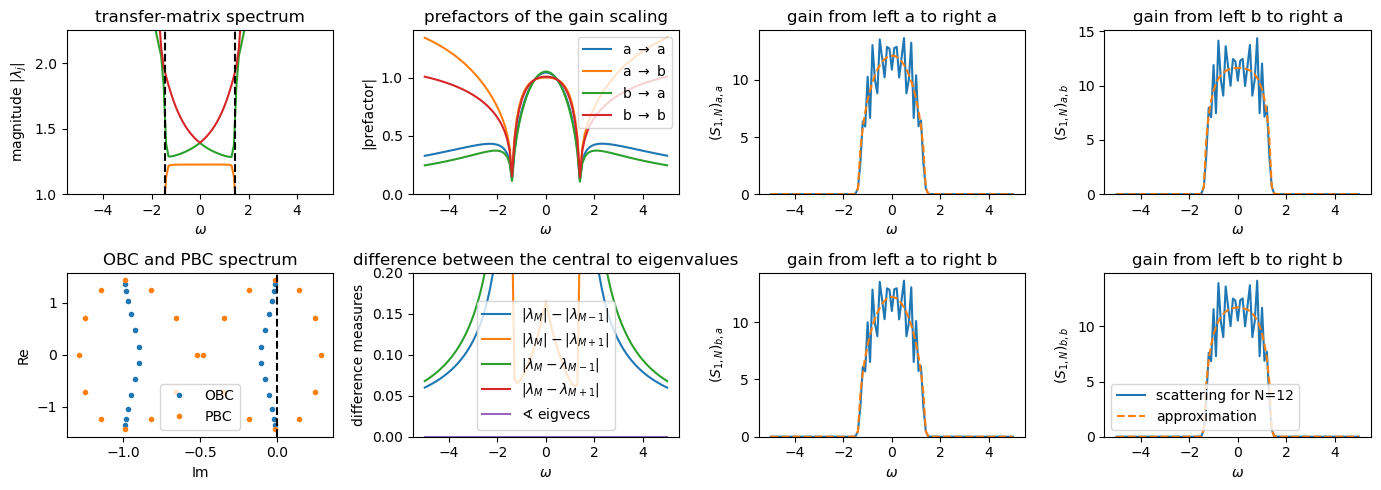

In [20]:
# plot exemplarily the transport properties of one of the discovered parameter sets

file_idx = 0 # feel free to vary this number

solution_dict = load_pickle(all_files[file_idx])
input_array = np.array([solution_dict[var] for var in all_var_names])

omegas = jnp.linspace(-5., 5., 101)

bandwidth = calc_bandwidth_jit(input_array)

fig, axes = phelp.create_fig(2, plot_functions, omegas, input_array, scaling_ylim=(1., gain_rate+0.5), target_gain=gain_rate)
axes[0,0].axvline(-bandwidth/2, color='black', ls='dashed')
axes[0,0].axvline(bandwidth/2, color='black', ls='dashed')

axes[0,0].set_title('transfer-matrix spectrum')
axes[0,0].set_ylabel('magnitude $|\lambda_j|$')

axes[0,1].set_title('prefactors of the gain scaling')
axes[0,2].set_title('gain from left a to right a')
axes[0,3].set_title('gain from left b to right a')
axes[1,2].set_title('gain from left a to right b')
axes[1,3].set_title('gain from left b to right b')

axes[1,0].set_xlabel('Im')
axes[1,0].set_ylabel('Re')
axes[1,0].set_title("OBC and PBC spectrum")
axes[1,1].set_title('difference between the central to eigenvalues')

fig.tight_layout()
plt.show()